<a href="https://colab.research.google.com/github/ayaehab/GP_task2/blob/main/PAB_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/ayaehab/GP_task2 cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 51 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.
/content/cloned-repo
 augmentation_of_data_skimage.ipynb   DFU.h5
 CELL_ARRAY.ipynb		      gp.ipynb
 CNN.ipynb			      Histogram.ipynb
'confusion matrix.ipynb'	      newcsv.ipynb
 data_splitter.py		      new_csvsheet.csv
 densenet_vol4_sigmoid.ipynb	      PartA_Abnormal_Sorted.csv
 densnet_vol1.ipynb		      PartA_Normal_Sorted.csv
 densnet_vol2.ipynb		      saving_augmented_images.ipynb
 densnet_vol3.ipynb		      transfere_learning0.ipynb


In [2]:
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, load_model, Model,Input

from keras.layers import Dense,GlobalAvgPool2D, Conv2D, MaxPool2D,AvgPool2D, GlobalAveragePooling2D,AveragePooling2D ,Softmax, BatchNormalization, ReLU, Dropout
from keras.layers import Flatten,Concatenate, Add,Lambda, Activation,Input
from keras.layers.convolutional import ZeroPadding2D

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array

from matplotlib.image import imread 
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from tensorflow.keras.callbacks import EarlyStopping


### new csv

In [ ]:
df = pd.read_csv("/content/cloned-repo/new_csvsheet.csv")
classes=["Abnormal","Infection","Ischemia"]
df


,Name,Abnormal,Infection,Ischemia
0,000501_10.jpg,0,0,0
1,000501_10_M.jpg,0,0,0
2,000501_20.jpg,0,0,0
3,000501_20_M.jpg,0,0,0
4,000501_30.jpg,0,0,0
...,...,...,...,...
12271,96_IMG_0301.jpg,0,0,0
12272,97_IMG_0303.jpg,0,0,0
12273,98_IMG_0304.jpg,0,0,0
12274,99_IMG_0306.jpg,0,0,0


In [ ]:
df.loc[df['Infection'] == 1, 'Abnormal'] = 1
df.loc[df['Ischemia'] == 1, 'Abnormal'] = 1
df

,Name,Abnormal,Infection,Ischemia
0,000501_10.jpg,0,0,0
1,000501_10_M.jpg,0,0,0
2,000501_20.jpg,0,0,0
3,000501_20_M.jpg,0,0,0
4,000501_30.jpg,0,0,0
...,...,...,...,...
12271,96_IMG_0301.jpg,0,0,0
12272,97_IMG_0303.jpg,0,0,0
12273,98_IMG_0304.jpg,0,0,0
12274,99_IMG_0306.jpg,0,0,0


1    8291
0    3985
Name: Abnormal, dtype: int64

In [ ]:
df.groupby('Abnormal').count()


,Name,Infection,Ischemia
Abnormal,,,
0,3985,3985,3985
1,8291,8291,8291


In [ ]:
df.to_csv("/content/drive/MyDrive/gp/PA&BLABELD.csv")

In [ ]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Name,Abnormal,Infection,Ischemia
0,001859_30_M.jpg,0,0,0
1,329_NormalFeet57.jpg,0,0,0
2,000711_20.jpg,0,1,0
3,000798_10.jpg,0,0,0
4,000732_31_R3.jpg,0,0,1
...,...,...,...,...
12271,2.08_257.jpg,1,0,0
12272,001675_20.jpg,0,0,0
12273,2.08_231.jpg,1,0,0
12274,001791_12_R1.jpg,0,0,1


In [ ]:
train_data_generation = ImageDataGenerator( samplewise_center=True,rescale = 1/255.)


training_set = train_data_generation.flow_from_dataframe(dataframe=df[:8000],
                                                         directory="/content/drive/MyDrive/gp/PARTA&B",
                                                         x_col="Name",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 1/255.)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[8000:10000],
                                                         directory="/content/drive/MyDrive/gp/PARTA&B",
                                                         x_col="Name",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 1/255.)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[10000:],
                                                         directory="/content/drive/MyDrive/gp/PARTA&B",
                                                         x_col="Name",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=2276,
                                                         class_mode="raw",seed=0, shuffle = False)

Found 8000 validated image filenames.
Found 2000 validated image filenames.
Found 2276 validated image filenames.


In [6]:
def densenet(img_shape, n_class,f=32):
  repetitions = [6, 12, 24, 16]
  
  def bn_rl_conv(model, f, k=1, s=1, p='same'):
    model = BatchNormalization()(model)
    model = ReLU()(model)
    model = Conv2D(f, k, strides=s, padding=p)(model)
    return model
  
  
  def dense_block(conc, r):
    for i in range(r):
      model = bn_rl_conv(conc, 4*f)
      model = bn_rl_conv(model, f, 3)
      conc = Concatenate()([conc, model])
    return conc
  
  
  def transition_block(model):
    model = bn_rl_conv(model, K.int_shape(model)[-1] // 2)
    model = AvgPool2D(2, strides=2, padding='same')(model)
    return model
  
  
  input = Input(img_shape)
  
  model = Conv2D(64, 7, strides=2, padding='same')(input)
  model = MaxPool2D(3, strides=2, padding='same')(model)
  
  for r in repetitions:
    d = dense_block(model, r)
    model = transition_block(d)
  
  model = GlobalAvgPool2D()(d)
  
  output = Dense(n_class, activation='sigmoid')(model)
  
  model = Model(input, output)
  return model

In [ ]:
model= densenet([224,224,3],3)
model.summary()

In [ ]:
early_s=EarlyStopping(monitor='val_binary_accuracy',patience=10,mode='max',restore_best_weights=True)

model.compile(optimizer='adam', loss = 'BinaryCrossentropy', metrics = ['binary_accuracy'])
history=model.fit(x=training_set, validation_data=valid_set, epochs=100,callbacks=([early_s]))

Epoch 1/100
250/250 [==============================] - 2696s 11s/step - loss: 0.4728 - binary_accuracy: 0.8218 - val_loss: 0.7454 - val_binary_accuracy: 0.7520
Epoch 2/100
250/250 [==============================] - 198s 794ms/step - loss: 0.3779 - binary_accuracy: 0.8434 - val_loss: 0.4422 - val_binary_accuracy: 0.8128
Epoch 3/100
250/250 [==============================] - 199s 794ms/step - loss: 0.3563 - binary_accuracy: 0.8510 - val_loss: 0.3325 - val_binary_accuracy: 0.8593
Epoch 4/100
250/250 [==============================] - 198s 794ms/step - loss: 0.3446 - binary_accuracy: 0.8550 - val_loss: 0.3408 - val_binary_accuracy: 0.8588
Epoch 5/100
250/250 [==============================] - 198s 794ms/step - loss: 0.3362 - binary_accuracy: 0.8567 - val_loss: 0.3202 - val_binary_accuracy: 0.8588
Epoch 6/100
250/250 [==============================] - 198s 793ms/step - loss: 0.3324 - binary_accuracy: 0.8567 - val_loss: 0.3203 - val_binary_accuracy: 0.8575
Epoch 7/100
250/250 [==============

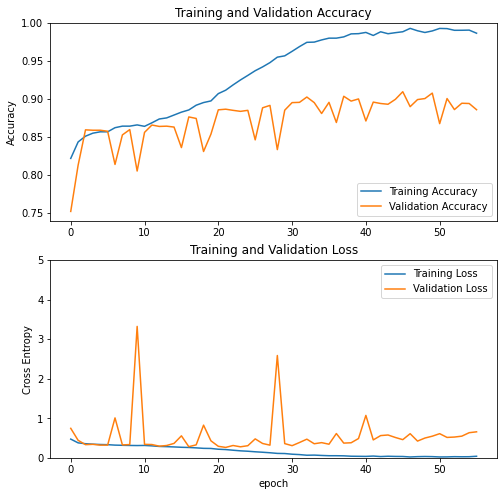

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions= model.predict(test_set[0][0])
print(pd.DataFrame(predictions))
y_pred=[]
for pred in predictions:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)

                 0             1             2
0     2.800359e-14  2.873536e-12  1.000000e+00
1     2.625472e-20  8.676805e-05  1.000000e+00
2     1.071575e-09  4.938435e-01  1.776926e-03
3     9.923998e-01  7.428542e-05  3.172565e-06
4     2.818415e-11  6.882817e-04  1.000000e+00
...            ...           ...           ...
2271  3.972199e-04  8.152257e-08  2.243207e-12
2272  3.666264e-07  6.079397e-10  5.103686e-15
2273  5.678202e-01  5.885924e-03  1.779542e-09
2274  3.424423e-07  1.203408e-04  9.848799e-01
2275  7.533645e-05  1.619968e-04  4.468049e-12

[2276 rows x 3 columns]


,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
2271,0.0,0.0,0.0
2272,0.0,0.0,0.0
2273,1.0,0.0,0.0
2274,0.0,0.0,1.0


In [ ]:

print(classification_report(test_set[0][1], y_pred,target_names=classes))

              precision    recall  f1-score   support

    Abnormal       0.83      0.41      0.55       193
   Infection       0.63      0.52      0.57       539
    Ischemia       0.95      0.94      0.95       907

   micro avg       0.85      0.74      0.79      1639
   macro avg       0.81      0.62      0.69      1639
weighted avg       0.83      0.74      0.78      1639
 samples avg       0.50      0.50      0.50      1639



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save("/content/drive/MyDrive/gp/PAB.h5")

### using label csv 

In [7]:
df = pd.read_csv("/content/drive/MyDrive/gp/PA&BLABELD.csv")
classes=["Abnormal","Infection","Ischemia"]
df

,Unnamed: 0,Name,Abnormal,Infection,Ischemia
0,0,000501_10.jpg,0,0,0
1,1,000501_10_M.jpg,0,0,0
2,2,000501_20.jpg,0,0,0
3,3,000501_20_M.jpg,0,0,0
4,4,000501_30.jpg,0,0,0
...,...,...,...,...,...
12271,12271,96_IMG_0301.jpg,0,0,0
12272,12272,97_IMG_0303.jpg,0,0,0
12273,12273,98_IMG_0304.jpg,0,0,0
12274,12274,99_IMG_0306.jpg,0,0,0


In [8]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Unnamed: 0,Name,Abnormal,Infection,Ischemia
0,4672,001191_30.jpg,1,1,0
1,8689,001781_20_R1_M.jpg,1,0,1
2,12094,3.08_12.jpg,1,0,0
3,5637,001344_30.jpg,0,0,0
4,2267,000860_30_R1.jpg,1,0,1
...,...,...,...,...,...
12271,10537,001986_21.jpg,1,1,0
12272,7086,001515_30_R3.jpg,1,0,1
12273,4327,001159_22_R2_M.jpg,1,0,1
12274,12102,3.08_88.jpg,1,0,0


In [24]:
train_data_generation = ImageDataGenerator( samplewise_center=True,rescale = 1/255.)


training_set = train_data_generation.flow_from_dataframe(dataframe=df[:8000],
                                                         directory="/content/drive/MyDrive/gp/PARTA&B",
                                                         x_col="Name",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 1/255.)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[8000:10000],
                                                         directory="/content/drive/MyDrive/gp/PARTA&B",
                                                         x_col="Name",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 1/255.)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[10000:],
                                                         directory="/content/drive/MyDrive/gp/PARTA&B",
                                                         x_col="Name",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=2276,
                                                         class_mode="raw",seed=0, shuffle = False)

Found 8000 validated image filenames.
Found 2000 validated image filenames.
Found 2276 validated image filenames.


In [ ]:
model= densenet([224,224,3],3)
model.summary()

In [13]:
early_s=EarlyStopping(monitor='val_binary_accuracy',patience=2,mode='max',restore_best_weights=True)

# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
       
model.compile(optimizer='adam', loss = 'BinaryCrossentropy', metrics = ['binary_accuracy'])
history=model.fit(x=training_set, validation_data=valid_set, epochs=100,callbacks=([early_s]))

Epoch 1/100
500/500 [==============================] - 3544s 7s/step - loss: 0.5450 - binary_accuracy: 0.7603 - val_loss: 0.4925 - val_binary_accuracy: 0.7622
Epoch 2/100
500/500 [==============================] - 105s 211ms/step - loss: 0.4506 - binary_accuracy: 0.7888 - val_loss: 0.4728 - val_binary_accuracy: 0.7788
Epoch 3/100
500/500 [==============================] - 106s 212ms/step - loss: 0.4394 - binary_accuracy: 0.7943 - val_loss: 0.4440 - val_binary_accuracy: 0.7892
Epoch 4/100
500/500 [==============================] - 106s 212ms/step - loss: 0.4200 - binary_accuracy: 0.8010 - val_loss: 0.3889 - val_binary_accuracy: 0.8045
Epoch 5/100
500/500 [==============================] - 106s 212ms/step - loss: 0.4065 - binary_accuracy: 0.8081 - val_loss: 0.4624 - val_binary_accuracy: 0.7748
Epoch 6/100
500/500 [==============================] - 106s 212ms/step - loss: 0.4026 - binary_accuracy: 0.8102 - val_loss: 0.4283 - val_binary_accuracy: 0.8172
Epoch 7/100
500/500 [===============

In [31]:
early_s=EarlyStopping(monitor='val_binary_accuracy',patience=10,mode='max',restore_best_weights=True)
       
model.compile(optimizer='adam', loss = 'BinaryCrossentropy', metrics = ['binary_accuracy'])
history=model.fit(x=training_set, validation_data=valid_set, epochs=100,callbacks=([early_s]))

Epoch 1/100
500/500 [==============================] - 128s 224ms/step - loss: 0.3706 - binary_accuracy: 0.8273 - val_loss: 0.3673 - val_binary_accuracy: 0.8245
Epoch 2/100
500/500 [==============================] - 108s 216ms/step - loss: 0.3669 - binary_accuracy: 0.8290 - val_loss: 0.3655 - val_binary_accuracy: 0.8320
Epoch 3/100
500/500 [==============================] - 108s 215ms/step - loss: 0.3598 - binary_accuracy: 0.8330 - val_loss: 0.4229 - val_binary_accuracy: 0.8117
Epoch 4/100
500/500 [==============================] - 107s 214ms/step - loss: 0.3527 - binary_accuracy: 0.8349 - val_loss: 0.3727 - val_binary_accuracy: 0.8215
Epoch 5/100
500/500 [==============================] - 107s 213ms/step - loss: 0.3471 - binary_accuracy: 0.8411 - val_loss: 0.3984 - val_binary_accuracy: 0.8090
Epoch 6/100
500/500 [==============================] - 107s 214ms/step - loss: 0.3361 - binary_accuracy: 0.8444 - val_loss: 0.3368 - val_binary_accuracy: 0.8422
Epoch 7/100
500/500 [=============

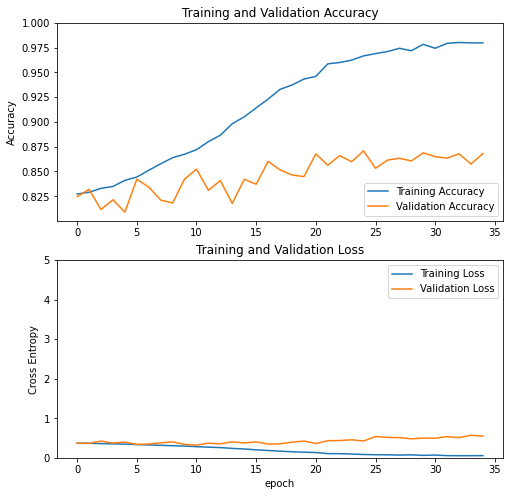

In [32]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
predictions= model.predict(test_set[0][0])
print(pd.DataFrame(predictions))
y_pred=[]
for pred in predictions:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)

             0             1             2
0     0.087133  2.466353e-02  3.675752e-07
1     0.999838  1.670970e-02  9.995931e-01
2     0.999402  1.979458e-03  9.997321e-01
3     0.572174  8.287416e-01  4.615428e-02
4     1.000000  8.537009e-01  9.999963e-01
...        ...           ...           ...
2271  0.993575  6.784040e-01  8.570963e-02
2272  1.000000  1.910035e-05  1.000000e+00
2273  1.000000  8.264653e-08  1.000000e+00
2274  0.982405  2.643647e-06  2.174196e-01
2275  0.999176  1.592013e-04  9.998677e-01

[2276 rows x 3 columns]


,0,1,2
0,0.0,0.0,0.0
1,1.0,0.0,1.0
2,1.0,0.0,1.0
3,1.0,1.0,0.0
4,1.0,1.0,1.0
...,...,...,...
2271,1.0,1.0,0.0
2272,1.0,0.0,1.0
2273,1.0,0.0,1.0
2274,1.0,0.0,0.0


In [34]:
# WITHOUT LEARNING RATE
print(classification_report(test_set[0][1], y_pred,target_names=classes))

              precision    recall  f1-score   support

    Abnormal       0.87      0.91      0.89      1524
   Infection       0.63      0.58      0.61       546
    Ischemia       0.91      0.95      0.93       912

   micro avg       0.84      0.86      0.85      2982
   macro avg       0.80      0.82      0.81      2982
weighted avg       0.84      0.86      0.85      2982
 samples avg       0.59      0.57      0.57      2982



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# WITHOUT LEARNING RATE epoch 9 
print(classification_report(test_set[0][1], y_pred,target_names=classes))

              precision    recall  f1-score   support

    Abnormal       0.78      0.92      0.85      1524
   Infection       0.54      0.17      0.26       546
    Ischemia       0.88      0.84      0.86       912

   micro avg       0.80      0.76      0.78      2982
   macro avg       0.73      0.64      0.65      2982
weighted avg       0.77      0.76      0.74      2982
 samples avg       0.60      0.51      0.54      2982



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
model.save("/content/drive/MyDrive/gp/PAB_LABELED_best.h5")

In [35]:
# model_LR= densenet([224,224,3],3)
early_s=EarlyStopping(monitor='val_binary_accuracy',patience=10,mode='max',restore_best_weights=True)

model_LR.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
history_LR=model_LR.fit(x=training_set, validation_data=valid_set, epochs=100,callbacks=([early_s]))

Epoch 1/100
500/500 [==============================] - 121s 219ms/step - loss: 0.2777 - binary_accuracy: 0.8754 - val_loss: 0.3513 - val_binary_accuracy: 0.8438
Epoch 2/100
500/500 [==============================] - 106s 212ms/step - loss: 0.2626 - binary_accuracy: 0.8842 - val_loss: 0.3586 - val_binary_accuracy: 0.8472
Epoch 3/100
500/500 [==============================] - 108s 215ms/step - loss: 0.2437 - binary_accuracy: 0.8932 - val_loss: 0.3892 - val_binary_accuracy: 0.8235
Epoch 4/100
500/500 [==============================] - 107s 215ms/step - loss: 0.2180 - binary_accuracy: 0.9066 - val_loss: 0.3455 - val_binary_accuracy: 0.8492
Epoch 5/100
500/500 [==============================] - 107s 213ms/step - loss: 0.2009 - binary_accuracy: 0.9164 - val_loss: 0.4074 - val_binary_accuracy: 0.8567
Epoch 6/100
500/500 [==============================] - 107s 213ms/step - loss: 0.1796 - binary_accuracy: 0.9258 - val_loss: 0.5606 - val_binary_accuracy: 0.8133
Epoch 7/100
500/500 [=============

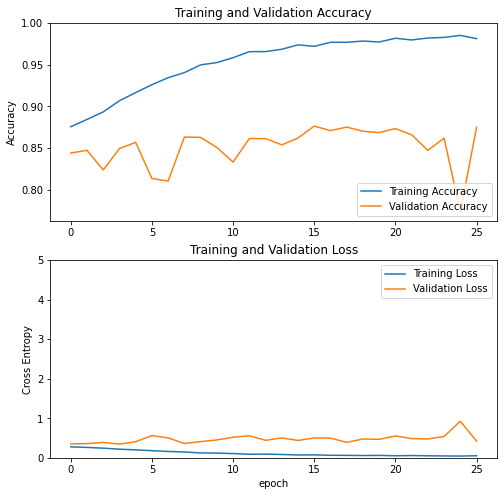

In [36]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history_LR.history['binary_accuracy']
val_acc = history_LR.history['val_binary_accuracy']

loss = history_LR.history['loss']
val_loss = history_LR.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
predictions= model_LR.predict(test_set[0][0])
print(pd.DataFrame(predictions))
y_pred_LR=[]
for pred in predictions:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred_LR.append(pred)

y_pred_LR = np.array(y_pred_LR)
pd.DataFrame(predictions)

             0             1         2
0     0.013490  1.546081e-05  0.000002
1     1.000000  5.619449e-09  0.999913
2     0.999154  9.666055e-01  0.105890
3     0.122876  2.514571e-01  0.003551
4     1.000000  6.657006e-06  1.000000
...        ...           ...       ...
2271  0.999928  9.938107e-01  0.009263
2272  0.999981  1.417714e-03  0.939116
2273  1.000000  5.987879e-12  1.000000
2274  0.419737  4.916031e-05  0.069037
2275  1.000000  2.040034e-12  1.000000

[2276 rows x 3 columns]


,0,1,2
0,0.0,0.0,0.0
1,1.0,0.0,1.0
2,1.0,1.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,1.0
...,...,...,...
2271,1.0,1.0,0.0
2272,1.0,0.0,1.0
2273,1.0,0.0,1.0
2274,0.0,0.0,0.0


In [38]:
# WITH LEARNING RATE 0.0001
print(classification_report(test_set[0][1], y_pred_LR,target_names=classes))

              precision    recall  f1-score   support

    Abnormal       0.90      0.88      0.89      1524
   Infection       0.81      0.47      0.59       546
    Ischemia       0.92      0.98      0.95       912

   micro avg       0.90      0.83      0.86      2982
   macro avg       0.88      0.77      0.81      2982
weighted avg       0.89      0.83      0.85      2982
 samples avg       0.58      0.55      0.56      2982



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# WITH LEARNING RATE 0.0001 epoch 9
print(classification_report(test_set[0][1], y_pred_LR,target_names=classes))

              precision    recall  f1-score   support

    Abnormal       0.89      0.84      0.86      1524
   Infection       0.62      0.38      0.47       546
    Ischemia       0.88      0.96      0.92       912

   micro avg       0.85      0.79      0.82      2982
   macro avg       0.80      0.73      0.75      2982
weighted avg       0.84      0.79      0.81      2982
 samples avg       0.55      0.52      0.53      2982



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
model_LR.save("/content/drive/MyDrive/gp/PAB_LABELED_LR_best.h5")

In [ ]:
sn